####                                                                                                                                                                                            Carol Chiu 
####                                                                                                                                                                                            April 17, 2020


# Wind Speed Time Series Forecasting Report

### Objective: 
######The goal of this project is to accurately and efficiently forecast wind speeds occurring at a powerplant operation in Hawaii. Hawaii is known for her high wind speeds with the average wind speed reaching as fast as 12 m/s in some regions such as Maui (8).
######As a powerplant operator, I am interested in protecting my special equipment that can only function properly when wind speeds are below 50 mph. I have a protection system installed for my equipment but it takes 5 minutes for the system to fully load and work. Thus, I need an accurate predictive model that I can use to sound an alarm when the wind speed might be greater than 50 mph in the next 5 minutes of the operation. Doing so will save me in damage costs to my powerplant and reduce health hazard and safety hazard costs to my employees, clients, and myself.
######For this project, I will be using data obtained from ASOS devices (Automated Surface Observing Systems) developed by the National Weather Service (NWS) for forecasting weather. The ASOS devices return wind speeds at 1 minutes intervals to the motherboard (9).

### Source of Data: 
######Please see ftp://ftp.ncdc.noaa.gov/pub/data/asos-onemin/ to obtain one minute data on wind speeds from ASOS.
######Details on the data can be found here: ftp://ftp.ncdc.noaa.gov/pub/data/asos-onemin/td6405.txt
######More information on ASOS systems is available: https://www.weather.gov/asos/

### Methods Used:
######1) ARIMA Model (one month, univariate model)
######2) VARMAX Model (one month, multivariate model)
######3) SARIMAX Model (one year, univariate, seasonal model)
######4) Hidden Markov Model (one year, multivariate model)
######5) Triple Exponential Smoothing Model (one year, univariate, trends, seasonality model)

### Exploratory Data Analysis for One Month (December 2001) :

In [1]:
#Import Packages and Read in CSV
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

data12 = pd.read_csv("./2001-12.csv")

In [2]:
#View DataFrame for the month of December 2001
data12

,Unnamed: 0,call_sign,ID,coef,d/n,max_speed,max_dir,avg_speed,avg_dir,month
0,107,14737KABE,ABE2001120101480648,0.146,N,211.0,7.0,198.0,8.0,12
1,243,14737KABE,ABE2001120104040904,0.481,N,202.0,3.0,198.0,3.0,12
2,244,14737KABE,ABE2001120104050905,0.478,N,199.0,3.0,197.0,3.0,12
3,245,14737KABE,ABE2001120104060906,0.630,N,197.0,3.0,196.0,3.0,12
4,246,14737KABE,ABE2001120104070907,0.983,N,197.0,3.0,197.0,3.0,12
...,...,...,...,...,...,...,...,...,...,...
2263,34740,14737KABE,ABE2001122903120812,0.071,N,201.0,1.0,196.0,1.0,12
2264,34742,14737KABE,ABE2001122903140814,0.076,N,199.0,2.0,198.0,2.0,12
2265,34743,14737KABE,ABE2001122903150815,0.076,N,197.0,2.0,196.0,2.0,12
2266,34794,14737KABE,ABE2001122904060906,0.084,N,211.0,3.0,199.0,3.0,12


In [3]:
#Fill in Missing Values with Linear Regression Imputation
def regression_imputation(df, impute_column, X_columns, missingness_column, regression = 'linear'):
    
    if regression == 'linear':
        model = LinearRegression()
    elif regression == 'logistic':
        model = LogisticRegression()
    
    model.fit(df[X_columns], df[impute_column])
    
    regression_impute = [df.loc[i,'avg_speed'] if df.loc[i,'avg_speed'] == 0
                         else model.predict(pd.DataFrame(df.loc[i,['coef', 'max_speed', 'max_dir',"avg_dir","month"]]).T)[0] 
                         for i in range(df.shape[0])]
    
    return regression_impute

In [4]:
data12['avg_speed_regression_imputed'] = regression_imputation(data12,'avg_speed', ['coef', 'max_speed', 'max_dir',"avg_dir","month"],'avg_speed')

In [5]:
#We want to convert our datatypes from Objects to Floats/Integers.
data12['avg_speed'] = pd.to_numeric(data12['avg_speed'])
data12['month'] = pd.to_numeric(data12['month'],errors='coerce')
data12['coef'] = pd.to_numeric(data12['coef'],errors='coerce')
data12['max_speed'] = pd.to_numeric(data12['max_speed'],errors='coerce')
data12['max_dir'] = pd.to_numeric(data12['max_dir'],errors='coerce')
data12['avg_dir'] = pd.to_numeric(data12['avg_dir'],errors='coerce')
data12['avg_speed_regression_imputed'] = pd.to_numeric(data12['avg_speed_regression_imputed'],errors='coerce')

In [6]:
#We only want certain columns that contain our values of interest in the final Dataframe.
data12 = data12[["coef","max_speed","max_dir","avg_speed","avg_dir","month","avg_speed_regression_imputed"]]


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


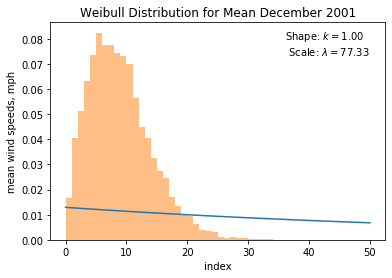

In [7]:
#Since the ARIMA model assumed our mean if normally distributed, we want to see if our mean is normally distributed.
from scipy import stats
import matplotlib.pyplot as plt

#input for pseudo data
N = 10000
Kappa_in = 1.8
Lambda_in = 10
a_in = 1
loc_in = 0 

#Generate data from given input
data = stats.exponweib.rvs(a=a_in,c=Kappa_in, loc=loc_in, scale=Lambda_in, size = N)

#The a and loc are fixed in the fit since it is standard to assume they are known
a_out, Kappa_out, loc_out, Lambda_out = stats.exponweib.fit(data12, f0=a_in,floc=loc_in)

#Plot
bins = range(51)
fig = plt.figure() 
ax = fig.add_subplot(1, 1, 1)
plt.title("Weibull Distribution for Mean December 2001")
plt.xlabel("index")
plt.ylabel("mean wind speeds, mph")
ax.plot(bins, stats.exponweib.pdf(bins, a=a_out,c=Kappa_out,loc=loc_out,scale = Lambda_out))
ax.hist(data, bins = bins , normed=True, alpha=0.5)
ax.annotate("Shape: $k = %.2f$ \n Scale: $\lambda = %.2f$"%(Kappa_out,Lambda_out), xy=(0.7, 0.85), xycoords=ax.transAxes)
plt.show()

#####Our mean is not normally distributed and is skewed to the right. See reference(3) below for article on how to use the Weibull distribution to transform our data to become normal so that the ARIMA assumption of normality is satisfied.

In [8]:
#Since our means are not normally distributed, we want to apply a Weibull distribution transformation to make our data Gaussian/ normal.

data12["avg_speed_imputed_transform"] = np.sqrt(np.sqrt(data12["avg_speed_regression_imputed"]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
mask1 = data12['avg_speed_imputed_transform']>0

In [10]:
data12= data12[mask1]

In [11]:
#View the completed DataFrame for December 2001
data12.head()

,coef,max_speed,max_dir,avg_speed,avg_dir,month,avg_speed_regression_imputed,avg_speed_imputed_transform
0,0.146,211.0,7.0,198.0,8.0,12,200.108448,3.761113
1,0.481,202.0,3.0,198.0,3.0,12,188.698452,3.706313
2,0.478,199.0,3.0,197.0,3.0,12,186.432626,3.695136
3,0.630,197.0,3.0,196.0,3.0,12,184.985096,3.687943
4,0.983,197.0,3.0,197.0,3.0,12,185.129551,3.688663


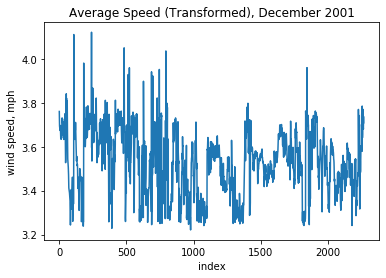

In [12]:
#View plot of Average Speed(Transformed) versus Time
plt.plot(data12['avg_speed_imputed_transform'].index, data12['avg_speed_imputed_transform'])
plt.title("Average Speed (Transformed), December 2001");
plt.xlabel("index");
plt.ylabel("wind speed, mph");

### Introduction to ARIMA Modeling on One Month (December 2001):
######1) ARIMA (Autoregressive Integrated Moving Average) model is a time series forecasting technique that predicts the future values of its own data based on its past history. The model appreciates data that has a consistent pattern over time (1). It has three parameters that define it: p, d, and q. The first parameter, d, is the "differencing" parameter which we use to make our time series stationary. The second parameter, p, is the "autoregressive" peice which is responsible for modeling the long-term trends in our data but does not handle sudden, random changes or "shocks." The last parameter, q, is the "moving average" peice which does handle sudden, random shocks in our model by using previous error inputs to our model to predict the next value based on deviations from previous predictions. The ARIMA model is a mixture of the "autoregressive" or AR component and the "moving average" or MA component where it predicts future values based on past data but can also account for "new information" or sudden shocks to the model (2).

In [13]:
#Create the ARIMA Model
# Apply the first and second differencing (d =1 and d = 2) to 
data12['first_diff'] = data12['avg_speed_imputed_transform'].diff(1)
data12['second_diff'] = data12['avg_speed_imputed_transform'].diff(1).diff(1)

In [14]:
#Use the Augmented Dickey-Fuller test to determine the value of d
from statsmodels.tsa.stattools import adfuller
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
interpret_dftest(adfuller(data12['avg_speed_imputed_transform']))

Test Statistic   -6.745710e+00
p-value           3.038926e-09
dtype: float64

In [16]:
interpret_dftest(adfuller(data12['first_diff'].dropna()))

Test Statistic   -1.385164e+01
p-value           6.987390e-26
dtype: float64

In [17]:
interpret_dftest(adfuller(data12['second_diff'].dropna()))

Test Statistic   -1.738517e+01
p-value           5.046345e-30
dtype: float64

#####Since the p-value for the target value is less than 5% without differencing, we can reject the null hypothesis that our data is not stationary and select d = 0.

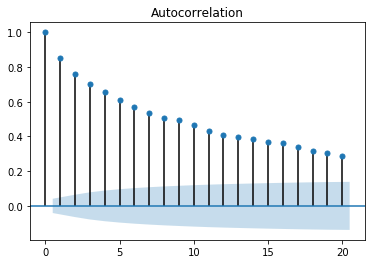

In [18]:
# Generate ACF and PACF plot to determine the value of p.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data12['avg_speed_imputed_transform'], lags = 20);

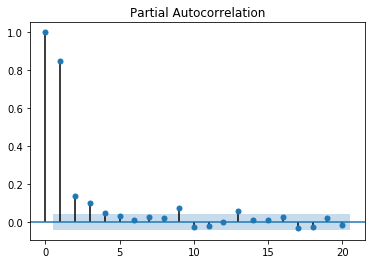

In [19]:
plot_pacf(data12['avg_speed_imputed_transform'], lags = 20);

In [20]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data12[['coef', 'max_speed', 'max_dir',"avg_dir","month"]],
                                                    data12['avg_speed_imputed_transform'],
                                                    test_size = 0.2,shuffle = False)

In [21]:
#Create the ARIMA model.
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(endog = y_train.astype(float).dropna(), 
              order = (0,0,1))

In [22]:
arima_0_1_0 = model.fit()

In [23]:
# Generate predictions.
start_index =X_train.index.min()+1
end_index = X_test.index.max()

preds = model.predict(params= arima_0_1_0.params, start=start_index, end=end_index)

In [24]:
data12['ARIMA_pred'] = pd.DataFrame(preds)

In [25]:
data12.head()

,coef,max_speed,max_dir,avg_speed,avg_dir,month,avg_speed_regression_imputed,avg_speed_imputed_transform,first_diff,second_diff,ARIMA_pred
0,0.146,211.0,7.0,198.0,8.0,12,200.108448,3.761113,NaN,NaN,3.633953
1,0.481,202.0,3.0,198.0,3.0,12,188.698452,3.706313,-0.054800,NaN,3.567978
2,0.478,199.0,3.0,197.0,3.0,12,186.432626,3.695136,-0.011176,0.043623,3.605626
3,0.630,197.0,3.0,196.0,3.0,12,184.985096,3.687943,-0.007194,0.003983,3.578984
4,0.983,197.0,3.0,197.0,3.0,12,185.129551,3.688663,0.000720,0.007913,3.597500


In [26]:
#Keep only positive values
neg = data12[data12.ARIMA_pred < 0]
data12 = data12.drop(neg.index)

In [27]:
#Fill NAs with zeros
data12 = data12.fillna(0)

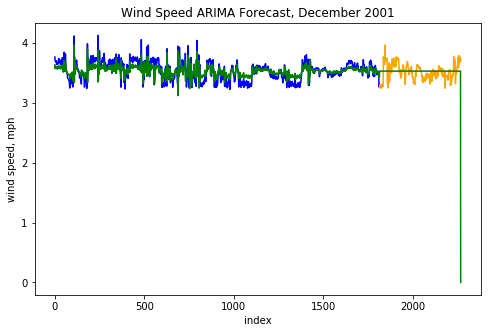

In [28]:
# Plot data.
plt.figure(figsize=(8,5))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')
# Plot predicted test values.
plt.plot(data12['ARIMA_pred'].index, data12['ARIMA_pred'] , color = 'green')
# Set label.
plt.title(label = 'Wind Speed ARIMA Forecast, December 2001');
plt.xlabel("index");
plt.ylabel("wind speed, mph");


#####Results: The ARIMA model has a low MSE and MSE and is good at predicting the average wind speeds for the powerplant. This may be due to the fact that we transformed the data into a stationary pattern, making it easier for the ARIMA to discern a pattern based on past history and predict consistently for the future wind speeds.

In [29]:
#Obtain scoring metrics for our model/
from sklearn.metrics import mean_squared_error
import statistics
import math
mse = mean_squared_error(data12['avg_speed_imputed_transform'],data12['ARIMA_pred'])
print("ARIMA MSE is:", mse)
rmse = math.sqrt(mse)
print("ARIMA RMSE is:", rmse)
mean1 = statistics.mean(data12['avg_speed_imputed_transform'])
print("Avg Wind Speed is:", mean1 )
mean2 = statistics.mean(data12['ARIMA_pred'])
print("Avg Wind Speed Prediction is:", mean2 )

ARIMA MSE is: 0.015549383441389068
ARIMA RMSE is: 0.12469716693409304
Avg Wind Speed is: 3.523245200444747
Avg Wind Speed Prediction is: 3.5242311070008188


### Intro to VARMAX Modeling on One Month (December 2001):

######VARMAX(Vector Autoregressive Moving Average) model, a multivariate model, adds to the ARIMA model, a univariate model, in two ways. It works with multiple response variables by forming a vector-based time series model. Als, it works with exogenous variables or variables that are independent of each other in the system. Thus, the model captures the multi-faceted relationship between the many variables in the system as well as the relationship between the independent and dependent variables (5).

In [30]:
data12.head()

,coef,max_speed,max_dir,avg_speed,avg_dir,month,avg_speed_regression_imputed,avg_speed_imputed_transform,first_diff,second_diff,ARIMA_pred
0,0.146,211.0,7.0,198.0,8.0,12,200.108448,3.761113,0.000000,0.000000,3.633953
1,0.481,202.0,3.0,198.0,3.0,12,188.698452,3.706313,-0.054800,0.000000,3.567978
2,0.478,199.0,3.0,197.0,3.0,12,186.432626,3.695136,-0.011176,0.043623,3.605626
3,0.630,197.0,3.0,196.0,3.0,12,184.985096,3.687943,-0.007194,0.003983,3.578984
4,0.983,197.0,3.0,197.0,3.0,12,185.129551,3.688663,0.000720,0.007913,3.597500


In [31]:
X_train, X_test, y_train, y_test = train_test_split(data12[['coef', 'max_speed', 'max_dir',"avg_dir","month", 'avg_speed_imputed_transform']],
                                                    data12['avg_speed_imputed_transform'],
                                                    test_size = 0.2,shuffle = False)

In [32]:
import statsmodels.api as sm
mod = sm.tsa.VARMAX(X_train, order=(0,1), error_cov_type='diagonal')
res = mod.fit(maxiter=10, disp=False)
print(res.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                                            Statespace Model Results                                                           
Dep. Variable:     ['coef', 'max_speed', 'max_dir', 'avg_dir', 'month', 'avg_speed_imputed_transform']   No. Observations:                 1814
Model:                                                                                          VMA(1)   Log Likelihood       -433894473695.960
                                                                                           + intercept   AIC                   867788947487.920
Date:                                                                                 Fri, 17 Apr 2020   BIC                   867788947752.078
Time:                                                                                         17:13:25   HQIC                  867788947585.393
Sample:                                                                                              0                                  

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [33]:
var_pred = res.predict(start= y_train.index.min(), end=y_test.index.max() )
var_pred['avg_speed_imputed_transform']

0       3.525812
1       3.826881
2       3.497244
3       3.515688
4       3.513661
          ...   
2263    3.525812
2264    3.525812
2265    3.525812
2266    3.525812
2267    3.525812
Name: avg_speed_imputed_transform, Length: 2268, dtype: float64

In [34]:
data12["VARMAX_pred"] = var_pred['avg_speed_imputed_transform']

In [35]:
mask = (data12['VARMAX_pred'] > 0)
data12 = data12[mask]

In [36]:
data12.head()

,coef,max_speed,max_dir,avg_speed,avg_dir,month,avg_speed_regression_imputed,avg_speed_imputed_transform,first_diff,second_diff,ARIMA_pred,VARMAX_pred
0,0.146,211.0,7.0,198.0,8.0,12,200.108448,3.761113,0.000000,0.000000,3.633953,3.525812
1,0.481,202.0,3.0,198.0,3.0,12,188.698452,3.706313,-0.054800,0.000000,3.567978,3.826881
2,0.478,199.0,3.0,197.0,3.0,12,186.432626,3.695136,-0.011176,0.043623,3.605626,3.497244
3,0.630,197.0,3.0,196.0,3.0,12,184.985096,3.687943,-0.007194,0.003983,3.578984,3.515688
4,0.983,197.0,3.0,197.0,3.0,12,185.129551,3.688663,0.000720,0.007913,3.597500,3.513661


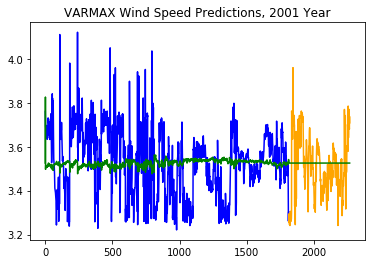

In [37]:
plt.plot(y_train.index,y_train, c = "blue")
plt.plot(y_test.index,y_test, c = "orange")
plt.plot(data12['VARMAX_pred'].index ,data12['VARMAX_pred'], c = "green")
plt.title("VARMAX Wind Speed Predictions, 2001 Year");

In [38]:
mse = mean_squared_error(data12['avg_speed_imputed_transform'],data12['VARMAX_pred'])
print("VARMAX MSE is:", mse)
rmse = math.sqrt(mse)
print("VARMAX RMSE is:", rmse)
mean1 = statistics.mean(data12['avg_speed_imputed_transform'])
print("Avg Wind Speed is:", mean1 )
mean2 = statistics.mean(data12['VARMAX_pred'])
print("Avg Wind Speed Prediction is:", mean2 )

VARMAX MSE is: 0.021439024574652205
VARMAX RMSE is: 0.14642071088016273
Avg Wind Speed is: 3.523245200444747
Avg Wind Speed Prediction is: 3.5259381017583165


### Introduction to SARIMAX Seasonal Model for All 12 Months (January- December 2001):
######SARIMA(Seasonal Autoregressive Integrated Moving Average) is a seasonal version of ARIMA. It adds to ARIMA by modeling univariate time series data with a seasonal component. SARIMA has three new hyperparameters that accounts for seasonality which are the autoregression (AR), differencing (I), and moving average (MA) parameters. Lastly, it has an additional parameter called the period of seasonality (6).

In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

data = pd.read_csv("./1-12_final.csv")

In [40]:
data

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,...,coef,d/n,max_speed,max_dir,avg_speed,avg_dir,month,VARMAX_pred,avg_speed_regression_imputed,avg_speed_imputed_transform
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.950,N,43.0,2.0,40.0,2.0,1,3.941545,41.042636,2.531097
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.974,N,40.0,2.0,41.0,2.0,1,3.084103,39.349417,2.504578
2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.728,N,36.0,2.0,23.0,2.0,1,2.356797,37.250066,2.470482
3,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,1.272,N,23.0,2.0,15.0,2.0,1,2.679792,30.231611,2.344851
4,4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,1.015,N,15.0,2.0,14.0,2.0,1,2.881641,25.899117,2.255907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107383,2263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071,NaN,201.0,1.0,196.0,1.0,12,NaN,185.301393,3.689518
107384,2264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.076,NaN,199.0,2.0,198.0,2.0,12,NaN,185.030913,3.688171
107385,2265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.076,NaN,197.0,2.0,196.0,2.0,12,NaN,183.521181,3.680625
107386,2266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.084,NaN,211.0,3.0,199.0,3.0,12,NaN,195.329784,3.738455


In [41]:
#Consolidate DataFrame to only contain Target Values
data = data[['coef',"max_speed","max_dir","avg_speed","avg_dir","month","VARMAX_pred","avg_speed_regression_imputed","avg_speed_imputed_transform"]]

In [42]:
data

,coef,max_speed,max_dir,avg_speed,avg_dir,month,VARMAX_pred,avg_speed_regression_imputed,avg_speed_imputed_transform
0,1.950,43.0,2.0,40.0,2.0,1,3.941545,41.042636,2.531097
1,1.974,40.0,2.0,41.0,2.0,1,3.084103,39.349417,2.504578
2,1.728,36.0,2.0,23.0,2.0,1,2.356797,37.250066,2.470482
3,1.272,23.0,2.0,15.0,2.0,1,2.679792,30.231611,2.344851
4,1.015,15.0,2.0,14.0,2.0,1,2.881641,25.899117,2.255907
...,...,...,...,...,...,...,...,...,...
107383,0.071,201.0,1.0,196.0,1.0,12,NaN,185.301393,3.689518
107384,0.076,199.0,2.0,198.0,2.0,12,NaN,185.030913,3.688171
107385,0.076,197.0,2.0,196.0,2.0,12,NaN,183.521181,3.680625
107386,0.084,211.0,3.0,199.0,3.0,12,NaN,195.329784,3.738455


In [43]:
#Prepare a Train-Test Split to run our models.
X_train, X_test, y_train, y_test = train_test_split(data[['coef', 'max_speed', 'max_dir',"avg_dir","month"]],
                                                    data['avg_speed_imputed_transform'],
                                                    test_size = 0.2,shuffle = False)

In [44]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [45]:
#Create SARIMAX model.
model = sm.tsa.statespace.SARIMAX(y_train,order=(0,1,0),seasonal_order=(0,1,1,12),trend='c')

In [46]:
results=model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:        avg_speed_imputed_transform   No. Observations:                85910
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood              -33791.121
Date:                            Fri, 17 Apr 2020   AIC                          67588.243
Time:                                    17:18:23   BIC                          67616.326
Sample:                                         0   HQIC                         67596.824
                                          - 85910                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.868e-06   1.89e-06     -2.580      0.010   -8.57e-06   -1.17e-06
ma.S.L12      -0.9990      0.000  -

In [47]:
data['SARIMAX_preds'] = results.predict(start=X_train.index.min(), end= X_test.index.max())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
data

,coef,max_speed,max_dir,avg_speed,avg_dir,month,VARMAX_pred,avg_speed_regression_imputed,avg_speed_imputed_transform,SARIMAX_preds
0,1.950,43.0,2.0,40.0,2.0,1,3.941545,41.042636,2.531097,-0.000005
1,1.974,40.0,2.0,41.0,2.0,1,3.084103,39.349417,2.504578,2.531092
2,1.728,36.0,2.0,23.0,2.0,1,2.356797,37.250066,2.470482,2.504573
3,1.272,23.0,2.0,15.0,2.0,1,2.679792,30.231611,2.344851,2.470478
4,1.015,15.0,2.0,14.0,2.0,1,2.881641,25.899117,2.255907,2.344847
...,...,...,...,...,...,...,...,...,...,...
107383,0.071,201.0,1.0,196.0,1.0,12,NaN,185.301393,3.689518,-206.545223
107384,0.076,199.0,2.0,198.0,2.0,12,NaN,185.030913,3.688171,-206.561790
107385,0.076,197.0,2.0,196.0,2.0,12,NaN,183.521181,3.680625,-206.589428
107386,0.084,211.0,3.0,199.0,3.0,12,NaN,195.329784,3.738455,-206.604186


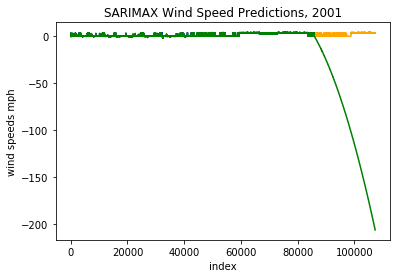

In [49]:
plt.plot(y_train.index, y_train, c = "blue")
plt.plot(y_test.index, y_test, c = "orange")
plt.plot(data['SARIMAX_preds'].index,data['SARIMAX_preds'], c ="green");
plt.title("SARIMAX Wind Speed Predictions, 2001")
plt.xlabel("index")
plt.ylabel("wind speeds mph");

In [50]:
#Remove NAs
data = data.dropna()

In [51]:
#Remove negative values
mask3 = data['SARIMAX_preds']>0
data = data[mask3]

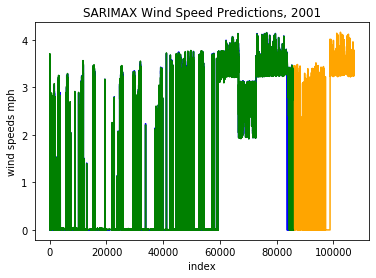

In [52]:
plt.plot(y_train.index, y_train, c = "blue")
plt.plot(y_test.index, y_test, c = "orange")
plt.plot(data['SARIMAX_preds'].index,data['SARIMAX_preds'], c ="green");
plt.title("SARIMAX Wind Speed Predictions, 2001")
plt.xlabel("index")
plt.ylabel("wind speeds mph");

In [53]:
#Obtain scoring metrics for our model.
mse = mean_squared_error(data['avg_speed_imputed_transform'],data['SARIMAX_preds'])
print("SARIMAX MSE is:", mse)
rmse = math.sqrt(mse)
print("SARIMAX RMSE is:", rmse)
mean1 = statistics.mean(data['avg_speed_imputed_transform'])
print("Avg Wind Speed is:", mean1 )
mean2 = statistics.mean(data['SARIMAX_preds'])
print("Avg Wind Speed Prediction is:", mean2 )

SARIMAX MSE is: 0.1598084424406864
SARIMAX RMSE is: 0.39976048133937203
Avg Wind Speed is: 2.235517925870703
Avg Wind Speed Prediction is: 2.2598102996774205


#####The SARIMAX model has a low MSE and RMSE and is good at predicting wind speeds until it reaches the end of the model and starts failing. I have excluded the negative predictions in the final plot and kept only positive ones. This model needs improvement.

### Introduction to Hidden Markov Model on All 12 Months (January-December 2001):
######The Markov Model time series forecasting follows the "Markov Property" which assumes that the probability of future states of the process depends only on the present state and not past states. In a Hidden Markov model, the current state of the process is "unknown" but we assume that there are observable behaviors or markers that tell us what the "true" state of the hidden process is. We need to know the existing possible states as well as the probability of transition between the states to determine the best course of action. If those values are unknown, they can be calculated using the "Viterbi" algorithm (7).

In [54]:
data

,coef,max_speed,max_dir,avg_speed,avg_dir,month,VARMAX_pred,avg_speed_regression_imputed,avg_speed_imputed_transform,SARIMAX_preds
1,1.974,40.0,2.0,41.0,2.0,1,3.084103,39.349417,2.504578,2.531092
2,1.728,36.0,2.0,23.0,2.0,1,2.356797,37.250066,2.470482,2.504573
3,1.272,23.0,2.0,15.0,2.0,1,2.679792,30.231611,2.344851,2.470478
4,1.015,15.0,2.0,14.0,2.0,1,2.881641,25.899117,2.255907,2.344847
5,0.997,15.0,2.0,15.0,2.0,1,2.613933,25.909365,2.256130,2.255902
...,...,...,...,...,...,...,...,...,...,...
85897,0.144,0.0,0.0,0.0,0.0,9,6.160540,0.000000,0.000000,0.000365
85902,0.182,0.0,0.0,0.0,0.0,9,6.160540,0.000000,0.000000,0.001330
85903,0.222,0.0,0.0,0.0,0.0,9,6.160540,0.000000,0.000000,0.003448
85907,0.202,0.0,0.0,0.0,0.0,9,6.160540,0.000000,0.000000,0.005909


In [55]:
data = data.dropna()

In [56]:
#Prepare a Train-Test Split to run our models.
X_train, X_test, y_train, y_test = train_test_split(data[['coef', 'max_speed', 'max_dir',"avg_dir","month"]],
                                                    data['avg_speed_imputed_transform'],
                                                    test_size = 0.2,shuffle = False)

In [57]:
from hmmlearn.hmm import GaussianHMM

In [58]:
hmm = GaussianHMM(n_components=6, covariance_type="full",algorithm='viterbi')

In [59]:
y_train = np.array(y_train)
y_train = np.reshape(y_train, (-1,1))

In [60]:
fitted_model = hmm.fit(y_train)

In [61]:
y_test = np.array(y_test)
y_test = np.reshape(y_test, (-1,1))

In [62]:
markov_pred = fitted_model.predict(y_test)

In [63]:
y_train = pd.DataFrame(y_train)

In [64]:
y_test = pd.DataFrame(y_test)

In [65]:
markov =pd.DataFrame(markov_pred)

In [66]:
markov

,0
0,5
1,4
2,0
3,0
4,0
...,...
9188,1
9189,1
9190,1
9191,1


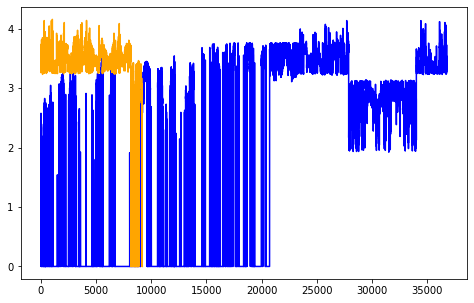

In [67]:
#View target data split into train and test portions of data.
plt.figure(figsize=(8,5))
plt.plot(y_train.index,y_train, c = 'blue');
plt.plot(y_test.index,y_test, c = 'orange');

In [68]:
y_test.shape

(9193, 1)

In [69]:
markov.shape

(9193, 1)

In [70]:
#Obtain scoring metrics for our model.
mse = mean_squared_error(y_test, markov)
print("MARKOV MSE is:", mse)
rmse = math.sqrt(mse)
print("MARKOV RMSE is:", rmse)
mean1 = statistics.mean(y_test[0])
print("Avg Wind Speed is:", mean1 )
mean2 = statistics.mean(markov[0])
print("Avg Wind Speed Prediction is:", mean2 )

MARKOV MSE is: 9.707508882211872
MARKOV RMSE is: 3.115687545664981
Avg Wind Speed is: 3.3926901585965834
Avg Wind Speed Prediction is: 0.5631458718590232


In [71]:
mask4 = markov > 0

In [72]:
markov = markov[mask4]

In [73]:
markov =markov.dropna()

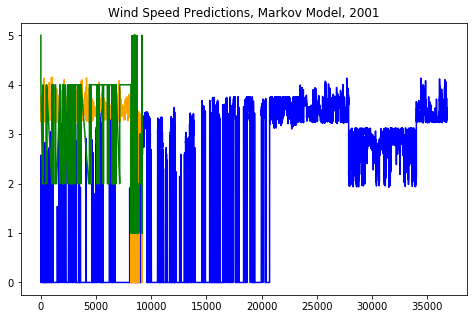

In [74]:
plt.figure(figsize=(8,5))
plt.plot(y_train.index,y_train, c = 'blue');
plt.plot(y_test.index,y_test, c = 'orange');
plt.plot(markov.index, markov, c = 'green');
plt.title("Wind Speed Predictions, Markov Model, 2001");

#######The Hidden Markov Model is the worst model yet but it has moderately low MSE and RMSE scores and decent predictive power of wind speeds. This model is a worse fit than the other models probably because Markov models are better at classification algorithms than continuous predictions. This model needs some improvement if it is to be applied to time series modeling more accurately. Also, please note that the green lines in the plot above overlap with y_test because I trained my model on y_train but tested it on y_test for accuracy.

### Introduction to Exponential Smoothing for Time Series Forecasting on All 12 Months (January-December 2001):

####Exponential smoothing forecasting is one of the best methods for time series forecasting in univariate data that can be used to include systematic trends and/or seasonal components. Time series methods such as the ARIMA model form predictions as a weighted linear sum of recent past observations or lags. Exponential smoothing forecasting is similar in that it also forms a weighted sum of past observations but it uses an exponentially decreasing weight for past observations. There are three forms to exponential smoothing but we will be using the most advanced form here which is the triple exponential smoothing method that accounts for systematic behavior including trends and seasonality (4)!

In [75]:
data = pd.read_csv("./1-12_final.csv")

In [76]:
#Consolidate DataFrame to only contain Target Values
data = data[['coef',"max_speed","max_dir","avg_speed","avg_dir","month","VARMAX_pred","avg_speed_regression_imputed","avg_speed_imputed_transform"]]

In [77]:
data

,coef,max_speed,max_dir,avg_speed,avg_dir,month,VARMAX_pred,avg_speed_regression_imputed,avg_speed_imputed_transform
0,1.950,43.0,2.0,40.0,2.0,1,3.941545,41.042636,2.531097
1,1.974,40.0,2.0,41.0,2.0,1,3.084103,39.349417,2.504578
2,1.728,36.0,2.0,23.0,2.0,1,2.356797,37.250066,2.470482
3,1.272,23.0,2.0,15.0,2.0,1,2.679792,30.231611,2.344851
4,1.015,15.0,2.0,14.0,2.0,1,2.881641,25.899117,2.255907
...,...,...,...,...,...,...,...,...,...
107383,0.071,201.0,1.0,196.0,1.0,12,NaN,185.301393,3.689518
107384,0.076,199.0,2.0,198.0,2.0,12,NaN,185.030913,3.688171
107385,0.076,197.0,2.0,196.0,2.0,12,NaN,183.521181,3.680625
107386,0.084,211.0,3.0,199.0,3.0,12,NaN,195.329784,3.738455


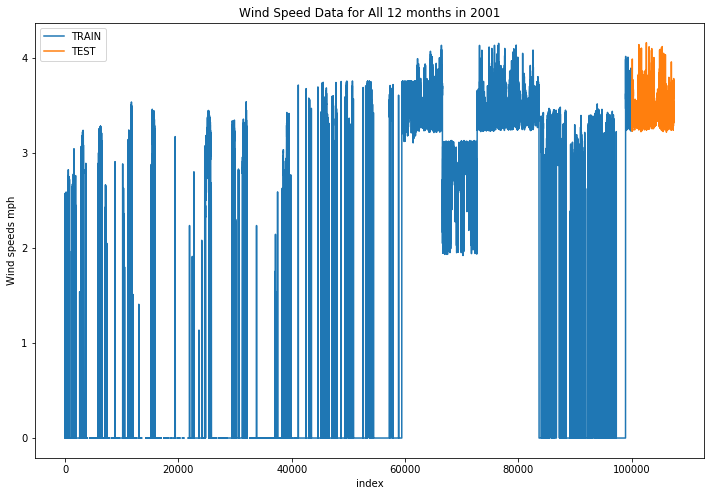

In [78]:
#Visualize the wind speed data for All 12 months in 2001
train = data.iloc[0:-7388,:]
test= data.iloc[-7388:, :]
train['avg_speed_imputed_transform'].plot(legend=True,label='TRAIN')
test['avg_speed_imputed_transform'].plot(legend=True,label='TEST',figsize=(12,8));
plt.title("Wind Speed Data for All 12 months in 2001");
plt.xlabel("index");
plt.ylabel("Wind speeds mph");

#####The months clearly exhibit heavy cycles for each season of the year in 2001. There seems to be steady wind speeds at 3.2 mph for Winter until Spring for the months of January until February. In Spring, March and April wind speeds increase to 3.7 mph while decreasing to an all-time low in May to 2.8 mph. For Summer, in the months of June, July, and August, wind speeds increase again to around 3.8 mph. In September, they decrease again to around 3.3 mph before rising again to 3.9 mph in October until December for the Fall. There are clearly seasonal wind patterns in our data to be observed.

In [79]:
data.loc[4]['month']

1.0

In [80]:
data = data[["coef","max_speed","max_dir","avg_speed","avg_dir","month","avg_speed_imputed_transform"]]

In [81]:
#Fill in Missing Values with Zeros
data = data.fillna(0)

In [82]:
#View our complete dataframe with target values consolidated.
data

,coef,max_speed,max_dir,avg_speed,avg_dir,month,avg_speed_imputed_transform
0,1.950,43.0,2.0,40.0,2.0,1,2.531097
1,1.974,40.0,2.0,41.0,2.0,1,2.504578
2,1.728,36.0,2.0,23.0,2.0,1,2.470482
3,1.272,23.0,2.0,15.0,2.0,1,2.344851
4,1.015,15.0,2.0,14.0,2.0,1,2.255907
...,...,...,...,...,...,...,...
107383,0.071,201.0,1.0,196.0,1.0,12,3.689518
107384,0.076,199.0,2.0,198.0,2.0,12,3.688171
107385,0.076,197.0,2.0,196.0,2.0,12,3.680625
107386,0.084,211.0,3.0,199.0,3.0,12,3.738455


In [83]:
data

,coef,max_speed,max_dir,avg_speed,avg_dir,month,avg_speed_imputed_transform
0,1.950,43.0,2.0,40.0,2.0,1,2.531097
1,1.974,40.0,2.0,41.0,2.0,1,2.504578
2,1.728,36.0,2.0,23.0,2.0,1,2.470482
3,1.272,23.0,2.0,15.0,2.0,1,2.344851
4,1.015,15.0,2.0,14.0,2.0,1,2.255907
...,...,...,...,...,...,...,...
107383,0.071,201.0,1.0,196.0,1.0,12,3.689518
107384,0.076,199.0,2.0,198.0,2.0,12,3.688171
107385,0.076,197.0,2.0,196.0,2.0,12,3.680625
107386,0.084,211.0,3.0,199.0,3.0,12,3.738455


In [84]:
#Prepare a Train-Test Split to run our models.
X_train, X_test, y_train, y_test = train_test_split(data[['coef', 'max_speed', 'max_dir',"avg_dir","month"]],
                                                    data['avg_speed_imputed_transform'],
                                                    test_size = 0.2,shuffle = False)

In [85]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# The model will consider the last 12 months weighted average for forecasting
span = 12 
alpha = 2/(span+1)
#For Exponential Smoothing, we are using "additive" trend and "additive" seasonal as well as setting the seasonal_periods to 12 for the 12 months. 
#We also define an alpha and beta to represent smoothing level and smoothing slope especially for the months at the end where the model starts leveling off.
model = ExponentialSmoothing(y_train.values,trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=alpha,smoothing_slope = 0.05)
#Make predictions on model.
test_predictions = model.predict(start=X_train.index.min(), end = X_test.index.max())

In [86]:
#Put predictions which are a numpy array into a DataFrame object
data['exp_smooth_preds']=pd.DataFrame(test_predictions)

In [87]:
#We want only positive values.
mask1 = (data['exp_smooth_preds']>0)

In [88]:
data = data[mask1]

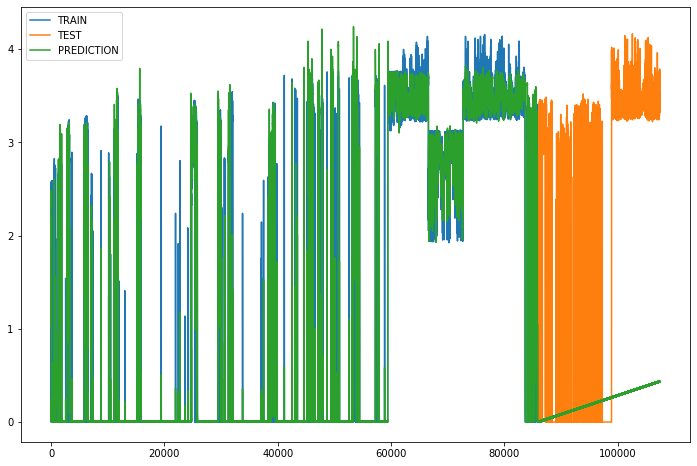

In [89]:
#Plot the predictions against the training and testing data for comparison.
y_train.plot(legend=True,label='TRAIN')
y_test.plot(legend=True,label='TEST',figsize=(12,8))
data['exp_smooth_preds'].plot(legend=True,label='PREDICTION');

#####Our triple exponential smoothing forecasting model is doing well for the months of January to July as it correctly uses additive trends and seasonal modifications to account for the cyclic and seasonal behavior of the twelve months. After it reaches around index = 85000 or from the months of August through December hereafter, the model fails and predicts nearly zero values for all the wind speeds. Then model depends on the most recent data to make its predictions so it might be having difficulties in obtaining enough recent data near the end of the model to make the last predictions. I attempt to smooth out the ends by setting a smoothing_slope = 0.05 to prevent the predictions from becoming zero when the actual values are non-zero for August to December. Future improvements need to be made on this model. However,the MSE and RMSE scores are low compared to the other models in terms of predictions so we have a reasonably accurate model.

In [90]:
#Obtain scoring metrics for our model.
mse = mean_squared_error(data['avg_speed_imputed_transform'],data['exp_smooth_preds'])
print("Exponential Smoothing MSE is:", mse)
rmse = math.sqrt(mse)
print("Exponential Smoothing RMSE is:", rmse)
mean1 = statistics.mean(data['avg_speed_imputed_transform'])
print("Avg Wind Speed is:", mean1 )
mean2 = statistics.mean(data['exp_smooth_preds'])
print("Avg Wind Speed Prediction is:", mean2 )

Exponential Smoothing MSE is: 1.9224685602249103
Exponential Smoothing RMSE is: 1.3865311248669863
Avg Wind Speed is: 1.9851955660668104
Avg Wind Speed Prediction is: 1.4462484734080439


### Executive Summary/ Results:
######The ARIMA, VARMAX, SARIMAX, and Triple Exponential Smoothing models did well in predicting wind speeds accurately based on past wind speeds. We obtained low RSME and MSE scores below 2 for all the models except the Hidden Markov model. We were also able to accommodate for cyclic trends and seasonal influence on high and low wind speeds every year with the SARIMAX and Triple Exponential Smoothing models. There seems to be steady wind at approximately 3.3 mph for the months of January and February (the Winter) with high winds at approximately 3.8 mph in mid-Spring(March and April), Summer(June, July, August), and mid-late Fall(October, November, and December).

In [91]:
import pandas as pd
sum_list = ["ARIMA","VARMAX","SARIMA","Hidden Markov","Exponential Smoothing"]
summary = pd.DataFrame(columns=sum_list)

In [92]:
summary["ARIMA"] = [0.01555,0.1247,3.523, 3.524, "2001 Dec (Winter)"]
summary["VARMAX"] = [0.02144,0.1464,3.523, 3.526, "2001 Dec (Winter)"]
summary["SARIMA"] = [0.1598,0.3998,2.236, 2.260, "2001 Full Year"]
summary["Hidden Markov"] = [2.614,1.617,3.393, 4.032, "2001 Oct-Dec(Fall)"]
summary["Exponential Smoothing "] = [1.922,1.387,1.985, 1.446, "2001 Full Year"]

In [93]:
summary = summary.rename(index={0: "MSE", 1 :"RMSE",2:"Mean Actual", 3:"Mean Predicted", 4:"Month"})

In [94]:
summary

,ARIMA,VARMAX,SARIMA,Hidden Markov,Exponential Smoothing,Exponential Smoothing
MSE,0.01555,0.02144,0.1598,2.614,NaN,1.922
RMSE,0.1247,0.1464,0.3998,1.617,NaN,1.387
Mean Actual,3.523,3.523,2.236,3.393,NaN,1.985
Mean Predicted,3.524,3.526,2.26,4.032,NaN,1.446
Month,2001 Dec (Winter),2001 Dec (Winter),2001 Full Year,2001 Oct-Dec(Fall),NaN,2001 Full Year


### References:
######1)Thurinav, Aars, "What is ARIMA?," Quora.com, Sept. 23, 2018, https://www.quora.com/What-is-ARIMA .
######2)Nelson, Joseph, "ARIMA Modeling," General Assembly, Data Science Immersive, June 15, 2019.
######3)Brown, Barbara G., "Time Series Models to Simulate and Forecast Wind Speed and Wind Power," Journal of Climate and Applied Meteorology, Vol 23, May, 22, 1984.
######4)Brownlee, Jason, "A Gentle Introduction to Exponential Smoothing for Time Series Forecasting in Python," Machine Learning Mastery, April 12, 2020, https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/.
######5)"VARMAX," Teradata Aster® Analytics Foundation User GuideUpdate 2, September 2007, https://docs.teradata.com/reader/3okbeHFSumK40IVQmGj6NQ/lMOhmxSUEJoxBnzmY9ehPA.
######6)Brownlee, Jason, "A Gentle Introduction to SARIMA for Time Series Forecasting in Python," Machine Learning Mastery, August 21, 2019, https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/.
######7)Sahu, Deepak Kumar, "Introduction to Hidden Markov Models using Python," DigitalVidya.com, May 3, 2018, https://www.digitalvidya.com/blog/markov-models/.
######8)"Wind Energy Resource Maps of Hawaii," AWS Truewind, LLC, June 30, 2004, https://energy.hawaii.gov/wp-content/uploads/2011/10/WindEnergyResourceMapsHawaii_AWSTruewind_2004.pdf
######9)"ASOS National Program Automated Surface Observing Systems," National Weather Service, https://www.weather.gov/asos/asostech, accessed April 17, 2020